In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os, glob
import re
from hutils import *

In [2]:
root = 'SynthHands_Release'

In [3]:
images = get_ipath(root)
df = pd.DataFrame({
    'images' : images
}).sort_values(by = 'images').reset_index(drop = True)
pd.set_option('display.max_colwidth', None)
df['imageID'] = df.images.str.split('/').str[-1].str.split('_').str[0]
df['abs_path'] = df.images.apply(os.path.dirname)
df['labels'] = df.images.str.split('/').str[1]
df.head()

,images,imageID,abs_path,labels
0,SynthHands_Release/female_noobject/seq01/cam01/01/00000000_color_on_depth.png,00000000,SynthHands_Release/female_noobject/seq01/cam01/01,female_noobject
1,SynthHands_Release/female_noobject/seq01/cam01/01/00000001_color_on_depth.png,00000001,SynthHands_Release/female_noobject/seq01/cam01/01,female_noobject
2,SynthHands_Release/female_noobject/seq01/cam01/01/00000002_color_on_depth.png,00000002,SynthHands_Release/female_noobject/seq01/cam01/01,female_noobject
3,SynthHands_Release/female_noobject/seq01/cam01/01/00000003_color_on_depth.png,00000003,SynthHands_Release/female_noobject/seq01/cam01/01,female_noobject
4,SynthHands_Release/female_noobject/seq01/cam01/01/00000004_color_on_depth.png,00000004,SynthHands_Release/female_noobject/seq01/cam01/01,female_noobject


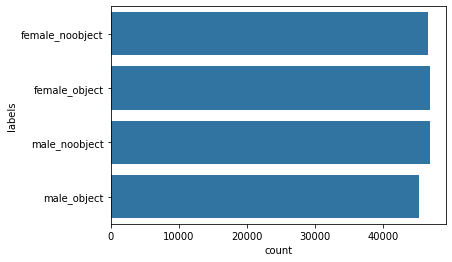

In [4]:
import seaborn as sns 


sns.countplot(df.labels);

In [15]:
from sklearn.model_selection import train_test_split

x, y = df.drop(['labels'], axis = 1), df.labels
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size = 0.1)

In [16]:
train_df = pd.concat([x_train, y_train], axis = 1).reset_index(drop = True)
test_df = pd.concat([x_test, y_test], axis = 1).reset_index(drop = True)
train_df.to_csv('synthetic_hand.csv', index = False)
test_df.to_csv('synthetic_hand_test.csv', index = False)

In [51]:
import torch
from torch.utils.data import Dataset, DataLoader

#### checkpoint

In [3]:
df = pd.read_csv('synthetic_hand_test.csv')
df.head()

,images,imageID,abs_path,labels
0,SynthHands_Release/male_noobject/seq04/cam05/0...,445,SynthHands_Release/male_noobject/seq04/cam05/01,male_noobject
1,SynthHands_Release/female_noobject/seq07/cam05...,451,SynthHands_Release/female_noobject/seq07/cam05/01,female_noobject
2,SynthHands_Release/male_object/seq03/cam04/02/...,190,SynthHands_Release/male_object/seq03/cam04/02,male_object
3,SynthHands_Release/female_noobject/seq01/cam03...,102,SynthHands_Release/female_noobject/seq01/cam03/03,female_noobject
4,SynthHands_Release/male_object/seq01/cam02/02/...,369,SynthHands_Release/male_object/seq01/cam02/02,male_object


In [4]:
df.values[[0,1]][0]

array(['SynthHands_Release/male_noobject/seq04/cam05/01/00000445_color_on_depth.png',
       445, 'SynthHands_Release/male_noobject/seq04/cam05/01',
       'male_noobject'], dtype=object)

In [75]:
class TrainValidIndex:
    def __init__(self, n_samples, frac, seed):
        np.random.seed(seed)
        idx_range      = np.arange(n_samples)
        valid_samples  = int(n_samples * frac)
        train_samples  = int(n_samples - valid_samples) 
        self.train_idx = np.random.choice(idx_range, train_samples)
        self.valid_idx = [i for i in idx_range if i not in self.train_idx]

class Loader(Dataset):
    def __init__(self, df, transform = None, subset = 'train', val_split = 0.1, seed = 0):
        splitIdx = TrainValidIndex(df.shape[0], val_split, seed)
        if subset == 'train':
            self.data = df.values[splitIdx.train_dx]
        else:
            self.data = df.values[splitIdx.valid_idx]
        
        self.transform = transform
        
    def __getitem__(self, index):
        ipath, iid, ab_path, _ = self.data[index]
        image = plt.imread(ipath)
        jpath = os.path.join(ab_path, f'{iid}_joint_pos.txt')
        joints = get_joints(jpath)
        kpts = convert_3d_to_2d(joints).astype(int)
        h,w,c = image.shape
        bbox = get_crop_uv(kpts, hw = (h, w), thresh = 30)
        if self.transform:
            image, kpts = self.transform(image, kpts, bbox)
        
        ### normalization
#       iage = image.astype(np.float32) / 255
        kpts = np.array(kpts).astype(np.uint32)
        kpts = (kpts.astype(np.float32) / 224).flatten()
        
        ### np - torch
        image = torch.from_numpy(image).permute(-1, 0, 1)
        kpts = torch.from_numpy(kpts)
        
        return image, kpts
        
    
    def __len__(self):
        return self.data.shape[0]

In [5]:
from data_loader import Loader

img_size = (299,299)
loader = Loader(df, img_size, crop_and_resize)
loader[0]

Length of training data : 16707
Length of testing data : 1857


(tensor([[[0.0039, 0.0211, 0.0173,  ..., 0.0000, 0.0000, 0.0000],
          [0.0012, 0.0159, 0.0140,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0137, 0.0126,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.8863, 0.8931, 0.8972,  ..., 0.0000, 0.0000, 0.0000],
          [0.8886, 0.8890, 0.8952,  ..., 0.0000, 0.0000, 0.0000],
          [0.8941, 0.8873, 0.8925,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0706, 0.0603, 0.0557,  ..., 0.0000, 0.0000, 0.0000],
          [0.0761, 0.0634, 0.0585,  ..., 0.0000, 0.0000, 0.0000],
          [0.0765, 0.0645, 0.0596,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.6647, 0.6664, 0.6682,  ..., 0.0000, 0.0000, 0.0000],
          [0.6639, 0.6629, 0.6658,  ..., 0.0000, 0.0000, 0.0000],
          [0.6667, 0.6632, 0.6658,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ...,

In [6]:
def get_rows(n, col):
    if n % col == 0:
        return n // col
    return (n // col) + 1

def torch_to_np(image, kpts):
    image = image.detach().permute(1, -1, 0).numpy()
    kpts = kpts.detach().numpy().reshape(-1, 2) * 224
    return image, kpts.astype(np.uint32)

def plot_loader(loader, n = 10, col = 5):
    idx = np.random.choice(len(loader), n)
    row = get_rows(n, col)
    plt.tight_layout()
    plt.style.use('dark_background')
    plt.figure(figsize = (4 * col, 4 * row))
    for e, i in enumerate(idx):
        plt.subplot(row, col, e+1)
        image, kpts = loader[i]
        image, kpts = torch_to_np(image, kpts)
        plt.imshow(renderPose(image, kpts))
        plt.title(image.shape)
        plt.axis(False)

In [7]:
i,k = loader[0]
i,k = torch_to_np(i, k)

In [8]:
from warnings import filterwarnings

filterwarnings('ignore')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


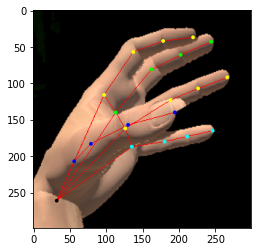

In [9]:
plt.imshow(renderPose(i,k))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

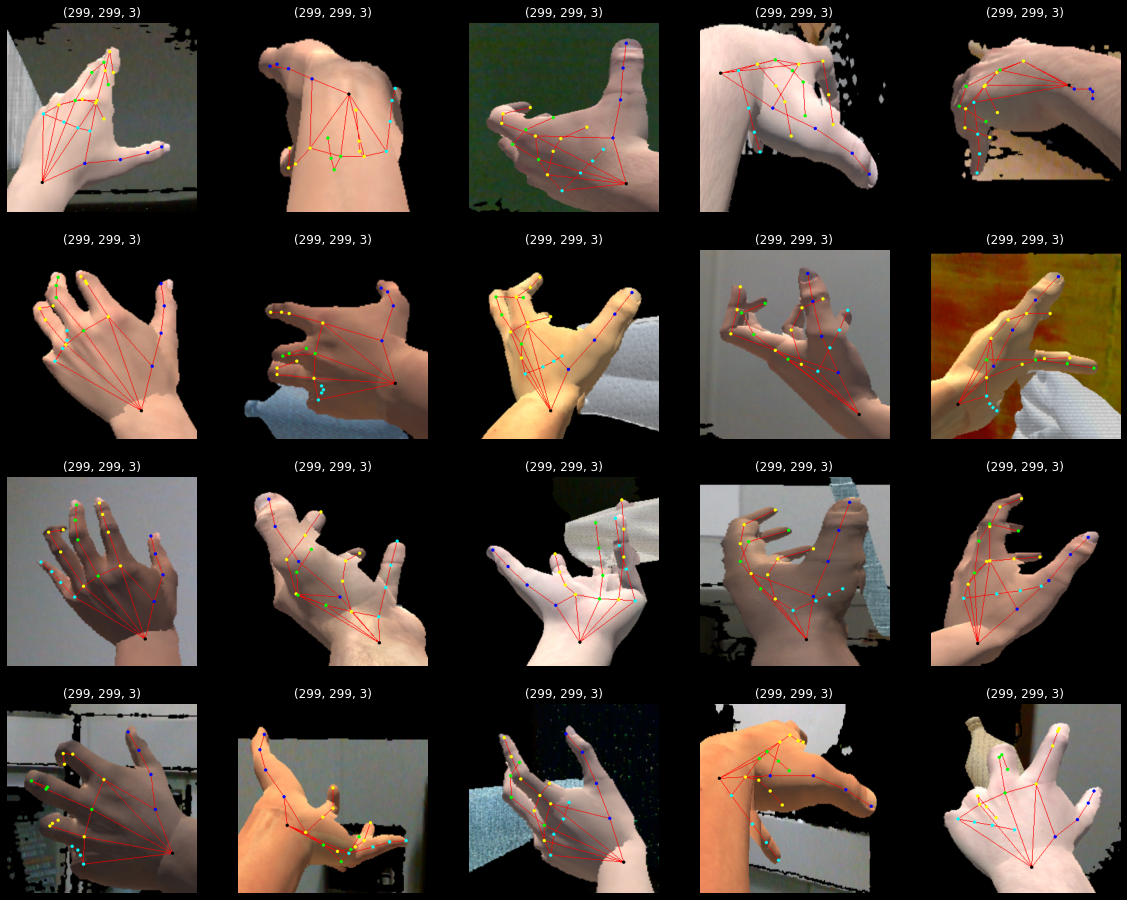

In [10]:
plot_loader(loader, 20, 5);